In [1]:
import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner
import matplotlib.pyplot as plt
print(torch.cuda.is_available())

# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:

def plot_timeseries(tensor, num_charts=5):
    """
    Plots time-series data for multiple stocks from the tensor in a grid layout with 5 charts per row.

    Parameters:
    - tensor (torch.Tensor): Time-series data with shape [num_stocks, time_steps].
    - num_charts (int): The number of charts to plot. Each chart corresponds to one stock.
    """
    # Check the number of stocks
    num_stocks, num_time_steps = tensor.shape

    # Ensure num_charts doesn't exceed the number of available stocks
    num_charts = min(num_charts, num_stocks)

    # Calculate the number of rows required for the grid
    rows = (num_charts + 4) // 5  # This ensures that we have a full row for the remaining charts

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    
    # Flatten axes array to easily index through them
    axes = axes.flatten()

    # Plot each stock's time-series data
    for i in range(num_charts):
        ax = axes[i]
        ax.plot(tensor[i].cpu().numpy())  # Move tensor to CPU and convert to numpy for plotting
        ax.set_title(f"Stock {i+1} - Time Series")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Stock Value")
        ax.grid(True)
    
    # Hide any unused subplots
    for i in range(num_charts, len(axes)):
        axes[i].axis('off')  # Hide the empty subplots

    plt.tight_layout()  # Adjust the layout to avoid overlap
    plt.show()


In [3]:
import torch
import math

# Parameters
n = 6000  # Number of data points
num_of_channels = 10   # Batch size

# Generate a time series of n points
t = torch.linspace(0, n // 100 * 2 * math.pi, n)

# Generate sine values for the batch
sin_values = torch.sin(t).unsqueeze(1).repeat(1, num_of_channels).transpose(0,1)

print(sin_values.shape)  # Should be [n, b]



torch.Size([10, 6000])


In [4]:
clean_data = sin_values.transpose(0, 1)

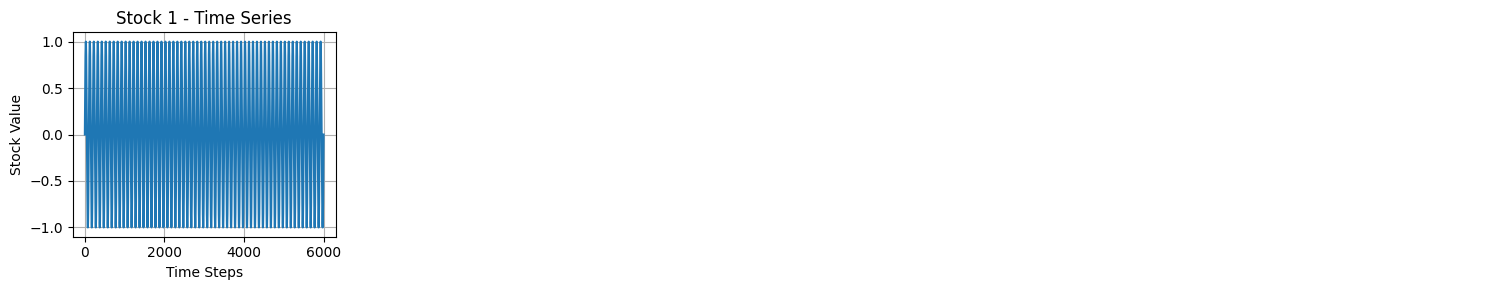

In [5]:
plot_timeseries(clean_data.to(dtype=torch.float32).transpose(0,1), num_charts=1)

In [6]:
from transformers import TorchTransformerModel2,TorchTransformerModel3,ConvKarpathyTransformerModel,TorchTransformerModel,FlashTransformerModel,KarpathyTransformerModel

config = TransformerConfig(
    # precision=torch.bfloat16,
    precision=torch.float32,
    batch_size=128,
    block_size=32,
    causal=True,
    input_embed=num_of_channels,
    n_embed=128,
    output_embed=num_of_channels,
    n_head=4,
    n_layer=4,
    learning_rate=1e-4
)
config.eval_interval=50

clean_data = clean_data.to(config.my_device)

trainer1 = TransformerRunner(config, TorchTransformerModel3(config), clean_data, clean_data)

trainer1.train_iterate_n(10000)

Using device: cuda
2.148106 M parameters
step 0: rmse train loss 0.7053, rmse val loss 0.7099, sec/iter 1.2636184692382812e-06
saved model version 1
step 50: rmse train loss 0.2418, rmse val loss 0.2432, sec/iter 0.029296941757202148
step 100: rmse train loss 0.2350, rmse val loss 0.2357, sec/iter 0.027003173828125
step 150: rmse train loss 0.2324, rmse val loss 0.2344, sec/iter 0.027065434455871583
step 200: rmse train loss 0.2320, rmse val loss 0.2324, sec/iter 0.027156119346618653
step 250: rmse train loss 0.2312, rmse val loss 0.2314, sec/iter 0.027198662757873537
step 300: rmse train loss 0.2294, rmse val loss 0.2309, sec/iter 0.02732046604156494
step 350: rmse train loss 0.2289, rmse val loss 0.2311, sec/iter 0.02707936763763428
step 400: rmse train loss 0.2286, rmse val loss 0.2295, sec/iter 0.027076807022094727
step 450: rmse train loss 0.2281, rmse val loss 0.2289, sec/iter 0.026993088722229004
step 500: rmse train loss 0.2276, rmse val loss 0.2297, sec/iter 0.0270001077651977

KeyboardInterrupt: 

In [7]:
context = clean_data[-config.block_size:, :].unsqueeze(0)  # Use last block_size days as context
print(f"context={context.shape}")

context=torch.Size([1, 32, 10])


In [10]:
prediction = trainer1.generate(context.to(dtype=config.precision), 500)[0,:,:].transpose(0,1).to(dtype=config.precision)

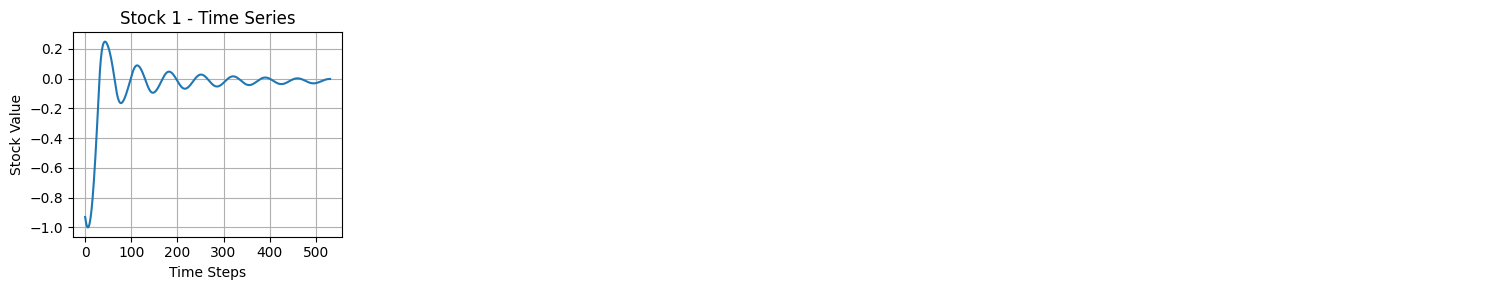

In [11]:
plot_timeseries(prediction.to(dtype=torch.float32), num_charts=1)